<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcolisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente. 

Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset:violación, acoso, secuestro, crímenes sexuales y homicidio.



**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

### 1. Importaciones y lecturas

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [4]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


c:\Users\badil\AppData\Local\Programs\Python\Python37\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

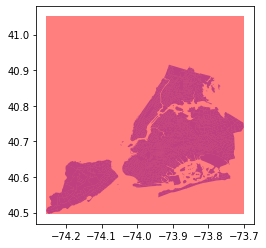

In [6]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [6]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [7]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [8]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


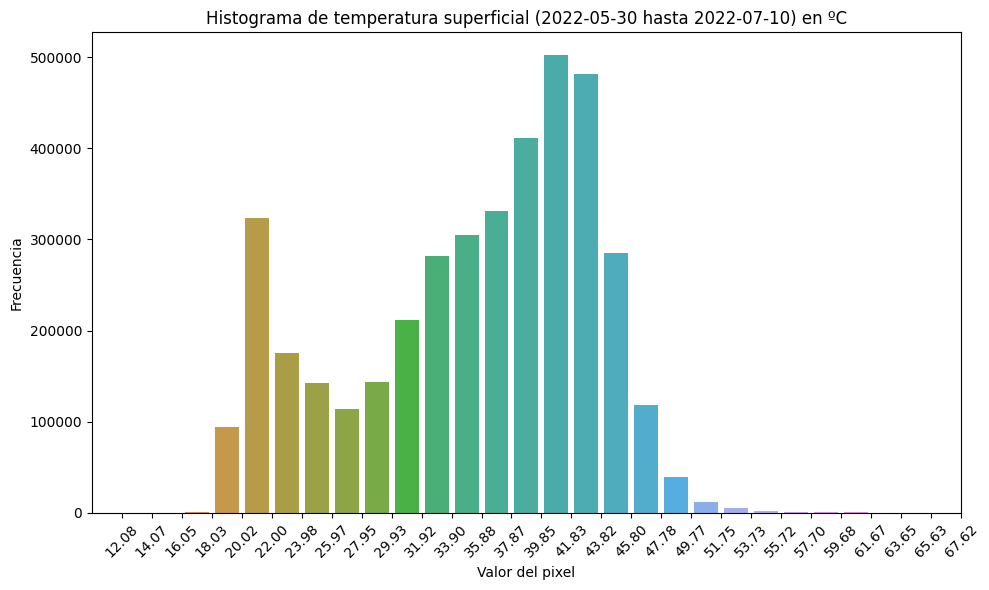

In [9]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [10]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [11]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [12]:
layer_list = []
for i in range(1, 11):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2022-{i}-30', f'2022-{i+2}-10').map(cloudMask)
    filtered= collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered_l8.map(applyScaleFactors)
    mean_ST = landsatST.mean()
    clip_mean_ST = mean_landsatST.clip(aoi)
    layer_list.append(clip_mean_ST)

In [13]:
layer_list

In [14]:
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

### 3. Visualizar información de crimenes

<Axes: >

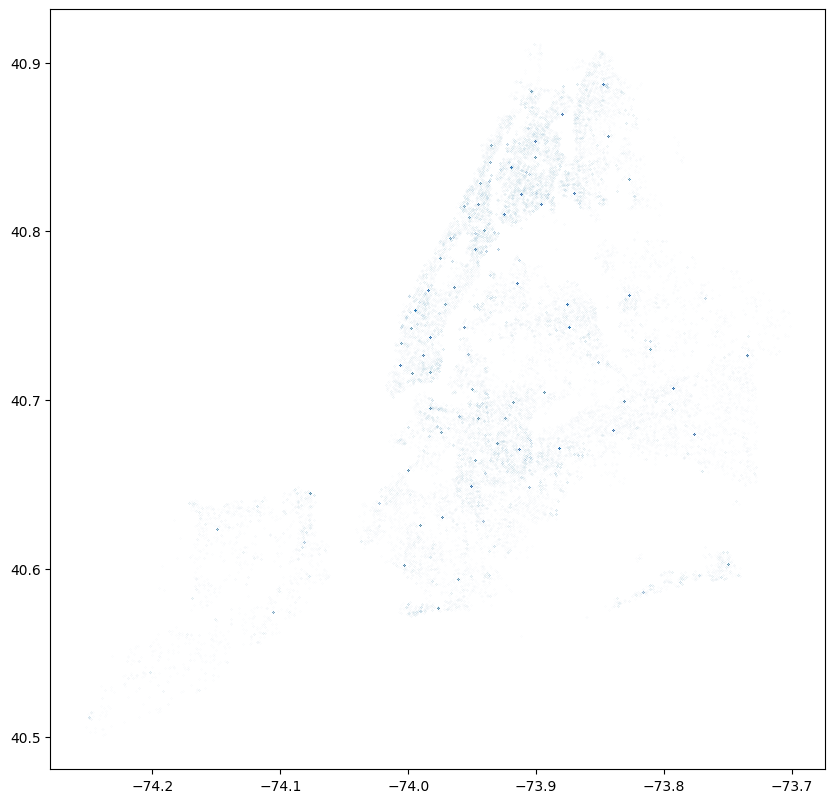

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
big_crimes.plot(ax=ax, alpha=0.1, markersize=0.01)

### 4. Extraer información de heat islands para el periodo relevante (2022)

In [5]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [6]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [7]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [8]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [9]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [10]:
def proportion(TotalPop, subgroup):
    if int(TotalPop) == 0:
        return 0
    else:
        return int(subgroup)/int(TotalPop)

In [18]:
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.Women, x.n_crimes), axis=1)
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,crimes_prop
54,101,1,Manhattan,010100,1010100,None,Midtown South-Flatiron-Union Square,MN0501,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,36061010100,4165,5701.715932,1.891378e+06,"POLYGON ((-73.98777 40.74979, -73.98797 40.749...",33,1259,501,0.397935,0.065868
1540,481,3,Brooklyn,048100,3048100,None,East Williamsburg,BK0104,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),36047048100,4301,5314.739370,1.629522e+06,"POLYGON ((-73.93870 40.71532, -73.93561 40.715...",4,3092,1752,0.566624,0.002283
1644,640,3,Brooklyn,064000,3064000,None,Marine Park-Mill Basin-Bergen Beach,BK1802,BK18,BK18 Canarsie-Flatlands (CD 18 Approximation),36047064000,4318,5734.951890,1.651212e+06,"POLYGON ((-73.93644 40.61207, -73.93715 40.611...",1,2017,1034,0.512643,0.000967


In [17]:
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,crimes_prop
1028,183,1,Manhattan,018300,1018300,None,Upper West Side (Central),MN0702,MN07,MN07 Upper West Side (CD 7 Approximation),36061018300,4107,6592.535335,2.391021e+06,"POLYGON ((-73.96942 40.79536, -73.96987 40.794...",20,8232,4443,0.539723,0.450146
1688,754,3,Brooklyn,075400,3075400,None,Midwood,BK1403,BK14,BK14 Flatbush-Midwood (CD 14 Approximation),36047075400,4314,5639.971975,1.867168e+06,"POLYGON ((-73.94837 40.61929, -73.94930 40.619...",1,1573,739,0.469803,0.135318
1865,580,4,Queens,058000,4058000,None,Queens Village,QN1303,QN13,QN13 Queens Village-Bellerose-Rosedale (CD 13 ...,36081058000,4413,11859.697680,5.917020e+06,"POLYGON ((-73.72697 40.71071, -73.72697 40.710...",15,3565,1903,0.533801,0.788229


<Axes: >

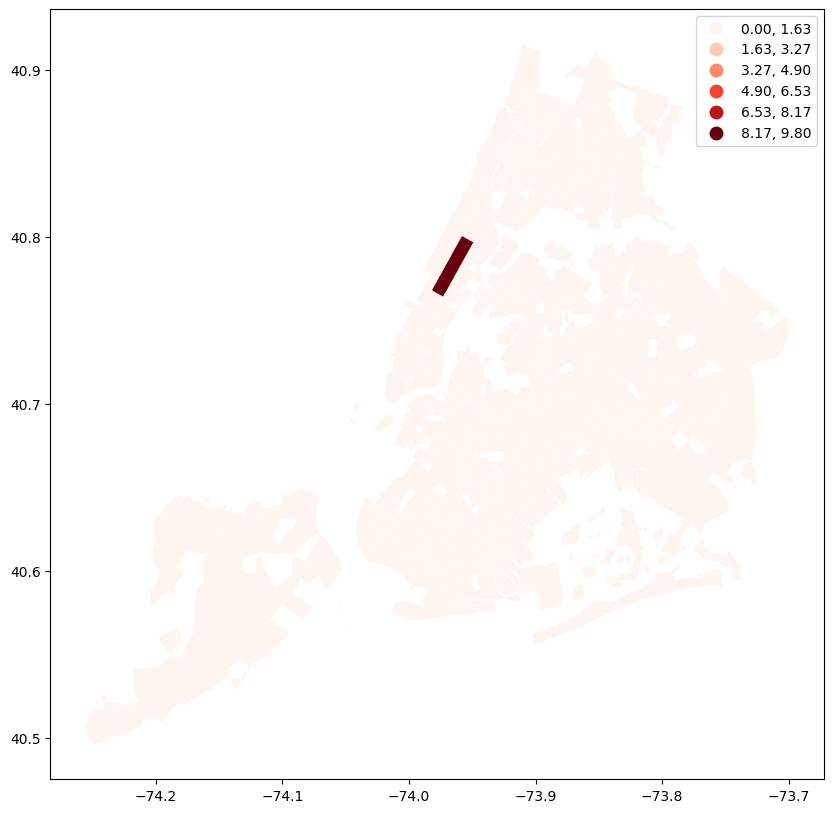

In [22]:
squares.plot(column='crimes_prop', scheme='EqualInterval', k=6, cmap='Reds', figsize=(10,10), legend=True)